In [2]:
from utils.model import light
from torch import nn

In [3]:
import torch
from torch._tensor import Tensor


class LeNet(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # layer 2
            nn.LazyConv2d(
                16,
                kernel_size=5,
            ),
            nn.ReLU(), # 
            nn.MaxPool2d(kernel_size=2, stride=2), # layer 5
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.ReLU(),
            nn.LazyLinear(84), # layer 9
            nn.ReLU(),
            nn.LazyLinear(config.output_size), # layer 11
        )

    def compute_loss(self, y_hat, y) -> Tensor:
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, x: Tensor):
        return self.net(x).argmax(dim=1)

    def predict_class(self, x: Tensor) -> Tensor:
        return self.predict(x).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }

In [4]:
# 数据准备
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
datapath = "../../data/"

# transformer = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.2860,), (0.3530,))
# ])

# # 加载数据集
# fashion_mnist_train = datasets.FashionMNIST(
#     root=datapath, train=True, download=True, transform=transformer
# )
# fashion_mnist_test = datasets.FashionMNIST(
#     root=datapath, train=False, download=True, transform=transformer
# )

# # 创建标准数据加载器 - 无需GPU包装器！
# train_loader = DataLoader(
#     fashion_mnist_train, 
#     batch_size=64, 
#     shuffle=True, 
# )
# val_loader = DataLoader(
#     fashion_mnist_test, 
#     batch_size=64, 
#     shuffle=False, 
# )

# num_classes = len(fashion_mnist_train.classes)

color_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10的RGB均值
            std=[0.2023, 0.1994, 0.2010],  # CIFAR-10的RGB标准差
        ),
    ]
)
# 加载 CIFAR-10 数据集
cifar10_train = datasets.CIFAR10(
    root=datapath, train=True, download=True, transform=color_transforms
)

cifar10_test = datasets.CIFAR10(
    root=datapath,
    train=False,
    download=True,
    transform=color_transforms,  # 测试时不使用数据增强
)

# 创建数据加载器
train_loader = DataLoader(
    cifar10_train, 
    batch_size=128, 
    shuffle=True, 
)

val_loader = DataLoader(
    cifar10_test, 
    batch_size=128, 
    shuffle=False, 
)

num_classes = 10  # CIFAR-10 有10个类别
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"数据集类别数: {num_classes}")

数据集类别数: 10


In [5]:
# 移植后的使用方式
import numpy as np
from scipy.stats import rankdata
# from infonet.infer_light import load_lightning_model, load_lightning_model_alternative
from infonet.infer import load_model

# 加载预训练模型
config_path = "../../configs/infonet/config.yaml"
ckpt_path = "../../data/checkpoint/infonet_cp/model_5000_32_1000-720--0.16.pt"

# try:
model = load_model(config_path, ckpt_path)
print("✅ 使用主要方法成功加载模型")
# except Exception as e:
    # print(f"❌ 主要方法失败: {e}")
    # print("🔄 尝试备用方法...")
    # model = load_lightning_model_alternative(config_path, ckpt_path)
    # print("✅ 使用备用方法成功加载模型")
    # print(f"❌ 加载模型失败: {e}")
# model.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"使用设备: {device}")
model = model.to(device)

# 通过parameter查看是否在cuda上
for name, param in model.named_parameters():
    if param.device.type == 'cuda':
        print(f"参数 {name} 在 CUDA 上")
    else:
        print(f"参数 {name} 不在 CUDA 上")

✅ 使用主要方法成功加载模型
参数 encoder.latents 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.q_norm.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.q_norm.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.kv_norm.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.kv_norm.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.qeury.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.qeury.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.key.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.key.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.value.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.value.bias 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.projection.weight 在 CUDA 上
参数 encoder.cross_attn_block.cross_attention.attention.projection.bias 在 CUDA 上
参数 encoder.cross_attn_block.mlp.mlp.0.weight 在 CUDA 上
参数 encoder.cross_attn_block.mlp

In [5]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only
import csv
import os
import m3logpy
from infonet.infer import compute_smi_mean

logger = m3logpy.M3Log("1.log")

class DemoCallBack_2(pl.Callback):
    def __init__(self, mi_model, csv_path="mi_epoch.csv", max_batches_for_mi=100, layer_count_mi=None
                 ,proj_num=1024, seq_len=2000, batchsize=16
                 ):
        """
        Args:
            mi_model: 用于计算互信息的预训练模型。
            csv_path (str): 保存结果的CSV文件路径。
            max_batches_for_mi (int): 每个epoch中用于计算MI的最大批次数，以防止内存溢出。
            layer_count_mi (list[int]): 需要统计互信息的层号列表。
        """
        super().__init__()
        self.seq_len = seq_len
        self.proj_num = proj_num
        self.batchsize = batchsize
        self.features = {}
        self.mi_model = mi_model
        self.csv_path = csv_path
        self.max_batches_for_mi = max_batches_for_mi
        self.layer_count_mi = layer_count_mi if layer_count_mi is not None else []

        # 用于累积数据的列表
        self.inputs_X_for_mi = []
        self.activations_output_for_mi = []

        # 用于每个指定层的激活累积，key为层号，value为list
        self.activations_layer_for_mi = {i: [] for i in self.layer_count_mi}

        # 写入表头 (使用 rank_zero_only 避免多GPU时重复写入)
        if rank_zero_only.rank == 0 and not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                # 动态生成表头
                header = ["epoch"]
                for i in self.layer_count_mi:
                    header.append(f"I(X;Layer_{i})")
                for i in self.layer_count_mi:
                    header.append(f"I(Layer_{i};Output)")
                writer.writerow(header)

    def get_activation(self, name):
        def hook(model, input, output):
            self.features[name] = output.detach().cpu()
        return hook

    def on_fit_start(self, trainer, pl_module):
        # 注册钩子以捕获中间层激活
        for i in self.layer_count_mi:
            pl_module.net[i].register_forward_hook(self.get_activation(f"Layer_{i}"))
        # 假设最后一层是输出
        pl_module.net[-1].register_forward_hook(self.get_activation("Output"))

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # 只在主进程中执行，并且只收集指定数量的批次
        if trainer.global_rank != 0 or batch_idx >= self.max_batches_for_mi:
            return

        x, y = batch
        self.inputs_X_for_mi.append(x.cpu())
        # 收集每个指定层的激活
        for i in self.layer_count_mi:
            feat = self.features.get(f"Layer_{i}")
            if feat is not None:
                self.activations_layer_for_mi[i].append(feat)
        # 收集输出层激活
        feat_out = self.features.get("Output")
        if feat_out is not None:
            self.activations_output_for_mi.append(feat_out)

    def compute_and_log_mi(self, x, y, name):
        # x, y: torch.Tensor
        x = x.cpu().numpy().reshape(x.shape[0], -1)
        y = y.cpu().numpy().reshape(y.shape[0], -1)
        seq_len = min(len(x), self.seq_len)
        # 只取前 seq_len 个样本
        x = x[:seq_len]
        y = y[:seq_len]
        mi = compute_smi_mean(x, y, self.mi_model, proj_num=self.proj_num, seq_len=seq_len, batchsize=self.batchsize)
        logger.info(f"本epoch {name} 互信息: {mi:.4f}")
        return mi

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.global_rank != 0:
            return

        epoch = trainer.current_epoch

        # 检查是否收集到了数据
        if not self.inputs_X_for_mi or not self.activations_output_for_mi:
            logger.warn(f"Epoch {epoch}: 未收集到足够的数据来计算互信息。")
            return

        all_X = torch.cat(self.inputs_X_for_mi, dim=0)
        all_T_output = torch.cat(self.activations_output_for_mi, dim=0)

        # 计算所有层的 I(X;T) 和 I(T;Output)
        mi_x_t = []
        mi_t_output = []
        for i in self.layer_count_mi:
            activations = self.activations_layer_for_mi[i]
            if activations:
                all_T = torch.cat(activations, dim=0)
                mi_x_t.append(self.compute_and_log_mi(all_X, all_T, f"Input(X) 与 Layer_{i}(T)"))
                mi_t_output.append(self.compute_and_log_mi(all_T, all_T_output, f"Layer_{i}(T) 与 Output(Y)"))
            else:
                mi_x_t.append(None)
                mi_t_output.append(None)

        # 保存到CSV
        with open(self.csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            row = [epoch]
            row.extend(mi_x_t)
            row.extend(mi_t_output)
            writer.writerow(row)

        # 清空所有累积
        self.inputs_X_for_mi.clear()
        self.activations_output_for_mi.clear()
        for i in self.layer_count_mi:
            self.activations_layer_for_mi[i].clear()

        logger.info(f"Epoch {epoch}: 互信息计算和记录完成。")

In [6]:
import os
import csv
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only
from infonet.infer import compute_smi_mean_gpu
class DemoCallBack_3(pl.Callback):
    def __init__(self, mi_model, csv_path="mi_epoch_gpu.csv", max_batches_for_mi=100, 
                 layer_count_mi=None, proj_num=1024, seq_len=2000, batchsize=16):
        """
        GPU优化版本的互信息计算回调
        """
        super().__init__()
        self.seq_len = seq_len
        self.proj_num = proj_num
        self.batchsize = batchsize
        self.features = {}
        self.mi_model = mi_model
        self.csv_path = csv_path
        self.max_batches_for_mi = max_batches_for_mi
        self.layer_count_mi = layer_count_mi if layer_count_mi is not None else []
        
        # 获取MI模型的设备
        self.device = next(mi_model.parameters()).device
        
        # 用于累积数据的列表 - 保持在GPU上
        self.inputs_X_for_mi = []
        self.activations_output_for_mi = []
        
        # 用于每个指定层的激活累积
        self.activations_layer_for_mi = {i: [] for i in self.layer_count_mi}
        
        # 写入表头
        if rank_zero_only.rank == 0 and not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                header = ["epoch"]
                for i in self.layer_count_mi:
                    header.append(f"I(X;Layer_{i})")
                for i in self.layer_count_mi:
                    header.append(f"I(Layer_{i};Output)")
                writer.writerow(header)

    def get_activation(self, name):
        def hook(model, input, output):
            # 保持激活在GPU上，不转移到CPU
            self.features[name] = output.detach()
        return hook

    def on_fit_start(self, trainer, pl_module):
        # 注册钩子以捕获中间层激活
        for i in self.layer_count_mi:
            pl_module.net[i].register_forward_hook(self.get_activation(f"Layer_{i}"))
        # 注册输出层钩子
        pl_module.net[-1].register_forward_hook(self.get_activation("Output"))

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # 只在主进程中执行，并且只收集指定数量的批次
        if trainer.global_rank != 0 or batch_idx >= self.max_batches_for_mi:
            return

        x, y = batch
        # 保持数据在GPU上
        self.inputs_X_for_mi.append(x.detach())
        
        # 收集每个指定层的激活 - 保持在GPU上
        for i in self.layer_count_mi:
            feat = self.features.get(f"Layer_{i}")
            if feat is not None:
                self.activations_layer_for_mi[i].append(feat)
        
        # 收集输出层激活
        feat_out = self.features.get("Output")
        if feat_out is not None:
            self.activations_output_for_mi.append(feat_out)

    def compute_and_log_mi_gpu(self, x, y, name):
        """GPU版本的互信息计算和日志记录"""
        # 保持张量格式，展平非批次维度
        if x.dim() > 2:
            x = x.flatten(1)
        if y.dim() > 2:
            y = y.flatten(1)
        
        # 调用GPU版本的计算函数
        mi = compute_smi_mean_gpu(
            x, y, self.mi_model, 
            proj_num=self.proj_num, 
            seq_len=self.seq_len, 
            batchsize=self.batchsize
        )
        
        logger.info(f"本epoch {name} 互信息 (GPU): {mi:.4f}")
        return mi

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.global_rank != 0:
            return

        epoch = trainer.current_epoch

        # 检查是否收集到了数据
        if not self.inputs_X_for_mi or not self.activations_output_for_mi:
            logger.warn(f"Epoch {epoch}: 未收集到足够的数据来计算互信息。")
            return

        # 在GPU上拼接数据
        all_X = torch.cat(self.inputs_X_for_mi, dim=0).to(self.device)
        all_T_output = torch.cat(self.activations_output_for_mi, dim=0).to(self.device)

        # 计算所有层的 I(X;T) 和 I(T;Output)
        mi_x_t = []
        mi_t_output = []
        
        for i in self.layer_count_mi:
            activations = self.activations_layer_for_mi[i]
            if activations:
                all_T = torch.cat(activations, dim=0).to(self.device)
                
                # 使用GPU版本计算互信息
                mi_x_layer = self.compute_and_log_mi_gpu(
                    all_X, all_T, f"Input(X) 与 Layer_{i}(T)"
                )
                mi_layer_output = self.compute_and_log_mi_gpu(
                    all_T, all_T_output, f"Layer_{i}(T) 与 Output(Y)"
                )
                
                mi_x_t.append(mi_x_layer)
                mi_t_output.append(mi_layer_output)
            else:
                mi_x_t.append(None)
                mi_t_output.append(None)

        # 保存到CSV
        with open(self.csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            row = [epoch]
            row.extend(mi_x_t)
            row.extend(mi_t_output)
            writer.writerow(row)

        # 清空所有累积（释放GPU内存）
        self.inputs_X_for_mi.clear()
        self.activations_output_for_mi.clear()
        for i in self.layer_count_mi:
            self.activations_layer_for_mi[i].clear()
        
        # 清理GPU缓存
        torch.cuda.empty_cache()

        logger.info(f"Epoch {epoch}: GPU互信息计算和记录完成。")

In [17]:
import m3logpy
import pytorch_lightning as pl

filepath = "mlp.log"

logger = m3logpy.M3Log(file_path=filepath)


class DemoCallBack(pl.Callback):
    def __init__(self, mi_model, csv_path="mi_epoch.csv"):
        super().__init__()
        self.features = {}
        self.mi_model = mi_model
        self.csv_path = csv_path
        # 写入表头
        if not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["epoch", "Flatten-ReLU", "ReLU-Output"])

    def get_activation(self, name):
        def hook(model, input, output):
            self.features[name] = output.detach().cpu()
        return hook

    def on_fit_start(self, trainer, pl_module):
        pl_module.net[0].register_forward_hook(self.get_activation("Flatten"))  # type: ignore
        pl_module.net[2].register_forward_hook(self.get_activation("ReLU"))     # type: ignore
        pl_module.net[3].register_forward_hook(self.get_activation("Output"))   # type: ignore

    def compute_and_log_mi(self, x, y, name):
        # x, y: torch.Tensor
        x = x.numpy().reshape(x.shape[0], -1)
        y = y.numpy().reshape(y.shape[0], -1)
        mi = compute_smi_mean(x, y, self.mi_model, proj_num=1024, seq_len=min(len(x), 2000), batchsize=16)
        logger.info(f"本epoch {name} 互信息: {mi:.4f}")
        return mi

    def on_train_epoch_end(self, trainer, pl_module):
        feat_flatten = self.features.get("Flatten")
        feat_relu = self.features.get("ReLU")
        feat_out = self.features.get("Output")
        epoch = trainer.current_epoch

        if feat_flatten is not None and feat_relu is not None and feat_out is not None:
            mi_flatten_relu = self.compute_and_log_mi(feat_flatten, feat_relu, "Flatten与ReLU")
            mi_relu_output = self.compute_and_log_mi(feat_relu, feat_out, "ReLU与Output")
            # 保存到csv
            with open(self.csv_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([epoch, mi_flatten_relu, mi_relu_output])
        else:
            logger.info("未获取到全部激活，无法计算互信息。")
        
        



In [ ]:

import torch
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only  # 保证只有主进程执行IO操作

# 假设 compute_smi_mean 和 mi_model 已经定义好了
# from your_mi_estimator import compute_smi_mean, build_mi_model
# mi_model = build_mi_model(...)

class DemoCallBack_1(pl.Callback):
    def __init__(self, mi_model, csv_path="mi_epoch.csv", max_batches_for_mi=100, layer_count_mi=[]):
        """
        Args:
            mi_model: 用于计算互信息的预训练模型。
            csv_path (str): 保存结果的CSV文件路径。
            max_batches_for_mi (int): 每个epoch中用于计算MI的最大批次数，以防止内存溢出。
        """
        super().__init__()
        self.features = {}
        self.mi_model = mi_model
        self.csv_path = csv_path
        self.max_batches_for_mi = max_batches_for_mi

        # 用于累积数据的列表
        self.inputs_X_for_mi = []
        self.activations_relu_for_mi = []
        
        # --- 新增的存储列表 ---
        # 如果您还想计算 I(T1; T2)，也需要为它们创建列表
        self.activations_flatten_for_mi = []
        self.activations_output_for_mi = []

        # 写入表头 (使用 rank_zero_only 避免多GPU时重复写入)
        if rank_zero_only.rank == 0 and not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                # 在表头中加入 I(X;T)
                writer.writerow(["epoch", "I(X;ReLU)", "I(Flatten;ReLU)", "I(ReLU;Output)"])

    def get_activation(self, name):
        def hook(model, input, output):
            self.features[name] = output.detach().cpu()
        return hook

    def on_fit_start(self, trainer, pl_module):
        # 注册钩子以捕获中间层激活
        # 循环注册layer_count_mi中的层
        for i in self.layer_count_mi:
            pl_module.net[i].register_forward_hook(self.get_activation(f"Layer_{i}"))

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """
        在每个训练批次结束后被调用。
        我们在这里收集输入数据X和中间激活T。
        """
        # 只在主进程中执行，并且只收集指定数量的批次
        if trainer.global_rank != 0 or batch_idx >= self.max_batches_for_mi:
            return

        # 从 batch 中解包输入 X
        # 假设 batch 是一个元组 (inputs, labels)
        x, y = batch
        
        # 检查 self.features 是否包含了当前批次的激活
        # feat_relu = self.features.get("ReLU")
        # if feat_relu is not None:
        #     self.inputs_X_for_mi.append(x.cpu())
        #     self.activations_relu_for_mi.append(feat_relu)
        
        # # 如果您还想计算 I(T1; T2)，也在这里收集
        # feat_flatten = self.features.get("Flatten")
        # feat_out = self.features.get("Output")
        # if feat_flatten is not None:
        #     self.activations_flatten_for_mi.append(feat_flatten)
        # if feat_out is not None:
        #     self.activations_output_for_mi.append(feat_out)

        # 收集输入数据和激活
        self.inputs_X_for_mi.append(x.cpu())
        # 收集layer_count_mi中指定的激活
        for i in self.layer_count_mi:
            feat = self.features.get(f"Layer_{i}")
            if feat is not None:
                self.activations_layer_for_mi.append(feat)

    def compute_and_log_mi(self, x, y, name):
        # x, y: torch.Tensor
        # 确保数据在CPU上，并转换为numpy
        x = x.cpu().numpy().reshape(x.shape[0], -1)
        y = y.cpu().numpy().reshape(y.shape[0], -1)
        
        # 使用您的互信息计算函数
        mi = compute_smi_mean(x, y, self.mi_model, proj_num=1024, seq_len=min(len(x), 2000), batchsize=16)
        logger.info(f"本epoch {name} 互信息: {mi:.4f}")
        return mi

    def on_train_epoch_end(self, trainer, pl_module):
        """
        在训练的epoch结束后，计算并记录累积数据的互信息。
        """
        # 只在主进程中执行计算和写入操作
        if trainer.global_rank != 0:
            return

        epoch = trainer.current_epoch

        # 检查是否收集到了数据
        if not self.inputs_X_for_mi or not self.activations_relu_for_mi:
            logger.warn(f"Epoch {epoch}: 未收集到足够的数据来计算互信息。")
            return

        # 将累积的批次数据拼接成一个大张量
        all_X = torch.cat(self.inputs_X_for_mi, dim=0)
        # all_T_relu = torch.cat(self.activations_relu_for_mi, dim=0)
        # all_T_flatten = torch.cat(self.activations_flatten_for_mi, dim=0)
        all_T_output = torch.cat(self.activations_output_for_mi, dim=0)

        # # 1. 计算 I(X; T_relu)
        # mi_x_relu = self.compute_and_log_mi(all_X, all_T_relu, "Input(X) 与 ReLU(T)")
        
        # # 2. 计算 I(T1; T2)
        # mi_flatten_relu = self.compute_and_log_mi(all_T_flatten, all_T_relu, "Flatten与ReLU")
        # mi_relu_output = self.compute_and_log_mi(all_T_relu, all_T_output, "ReLU与Output")

        # # 3. 保存到CSV
        # with open(self.csv_path, "a", newline="") as f:
        #     writer = csv.writer(f)
        #     writer.writerow([epoch, mi_x_relu, mi_flatten_relu, mi_relu_output])

        # # 4. 清空列表，为下一个epoch做准备
        # self.inputs_X_for_mi.clear()
        # self.activations_relu_for_mi.clear()
        # self.activations_flatten_for_mi.clear()
        # self.activations_output_for_mi.clear()
        
        # 循环计算所有包含在layer_count_mi中的层的I(X; T) 和 I(T;Y)
        mi_results = {}
        for i in self.layer_count_mi:
            feat = self.features.get(f"Layer_{i}")
            if feat is not None:
                mi_results[f"I(X; Layer_{i})"] = self.compute_and_log_mi(all_X, feat, f"Input(X) 与 Layer_{i}(T)")
                mi_results[f"I(Layer_{i}; Output)"] = self.compute_and_log_mi(feat, all_T_output, f"Layer_{i}(T) 与 Output(Y)") 
        # 保存到CSV
        with open(self.csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            row = [epoch]
            for key in sorted(mi_results.keys()):
                row.append(mi_results[key])
            writer.writerow(row)
        # 清空列表，为下一个epoch做准备
        self.inputs_X_for_mi.clear()
        self.activations_relu_for_mi.clear()
        self.activations_flatten_for_mi.clear()
        

        logger.info(f"Epoch {epoch}: 互信息计算和记录完成。")

In [7]:
config_LeNet = light.ModelConfig(
    lr=0.0001,
    num_hiddens=256,
    output_size=num_classes,
    optimizer="adam",
    # 权重衰减
    weight_decay=0.0001,  # 可选的权重衰减
    dropout_rate=0.2,
)

model_ = LeNet(config_LeNet)
model_.to("cuda" if torch.cuda.is_available() else "cpu")
print(model_.device)
print("cuda" if torch.cuda.is_available() else "cpu")

trainer = light.TrainerFactory.basic(
    max_epochs=200,
)
trainer.add_callback(DemoCallBack_3(
    mi_model=model,
    layer_count_mi=[2,5,9,11],
    seq_len=1000,
    proj_num=512,
    batchsize=16,
    csv_path="lenet_mi.csv"  # 保存互信息结果的CSV文件路径
))
trainer.add_callback(
    light.HighFrequencyLiveLossPlotCallback(update_every_n_batches=300
                                            )
)

cuda:0
cuda


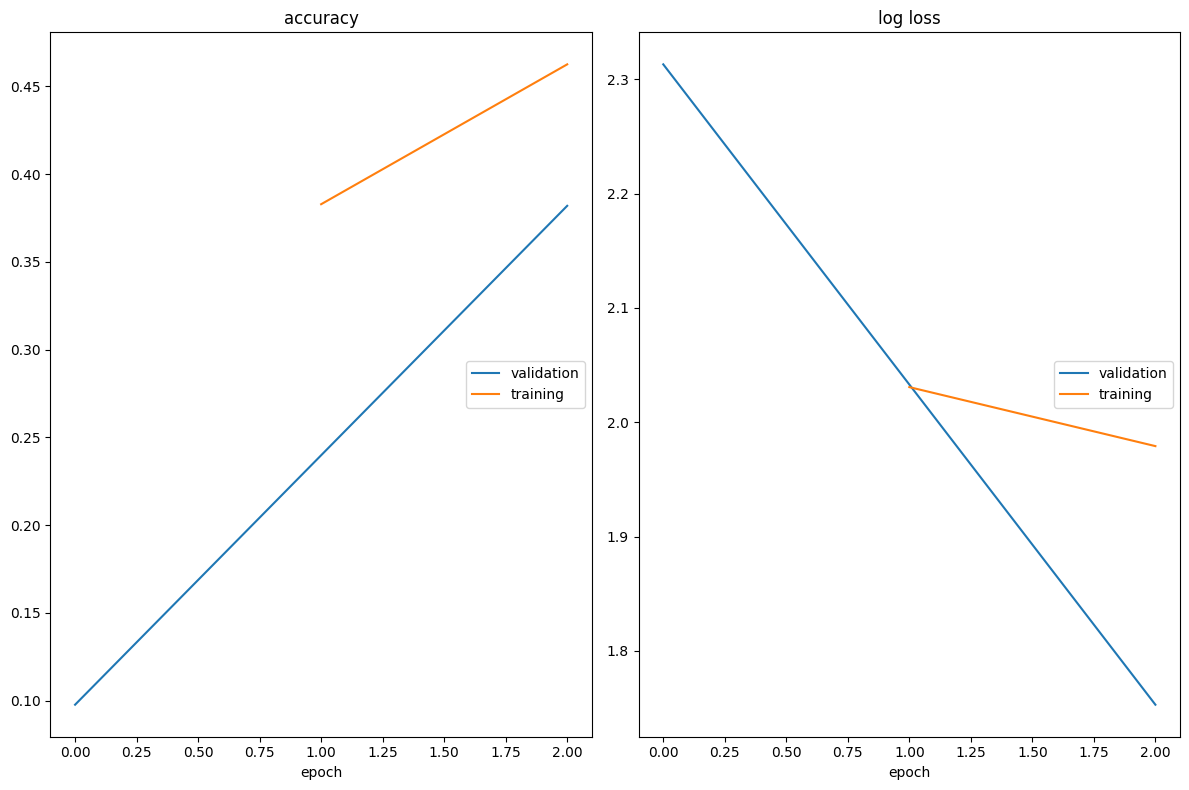

accuracy
	validation       	 (min:    0.098, max:    0.382, cur:    0.382)
	training         	 (min:    0.383, max:    0.463, cur:    0.463)
log loss
	validation       	 (min:    1.753, max:    2.313, cur:    1.753)
	training         	 (min:    1.979, max:    2.031, cur:    1.979)
Epoch 0: 100%|██████████| 391/391 [00:13<00:00, 28.00it/s, v_num=21, train_loss=1.690, train_acc=0.463, val_loss=1.750, val_acc=0.382]

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [8]:
trainer.fit(
    model=model_,
    train_loader=train_loader,
    val_loader=val_loader,
)

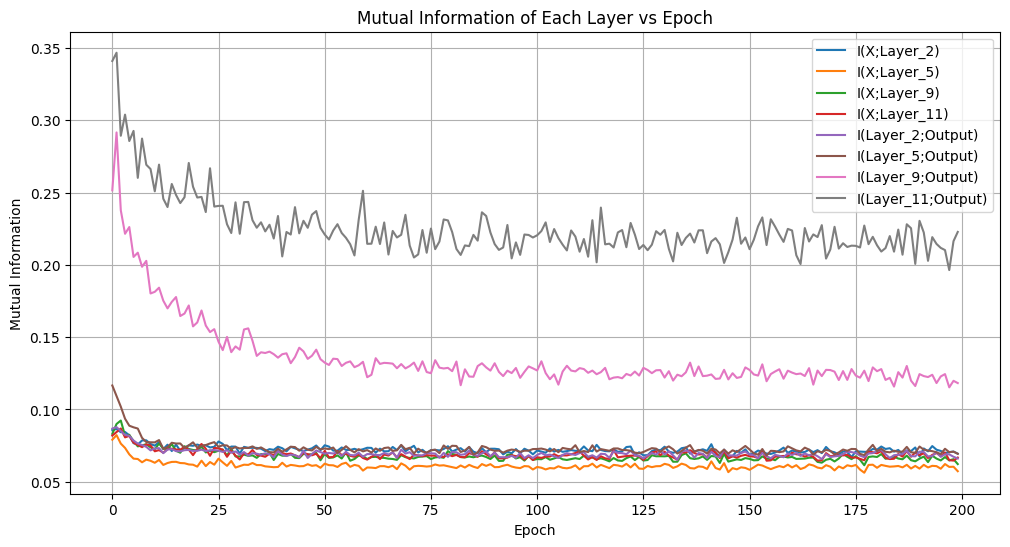

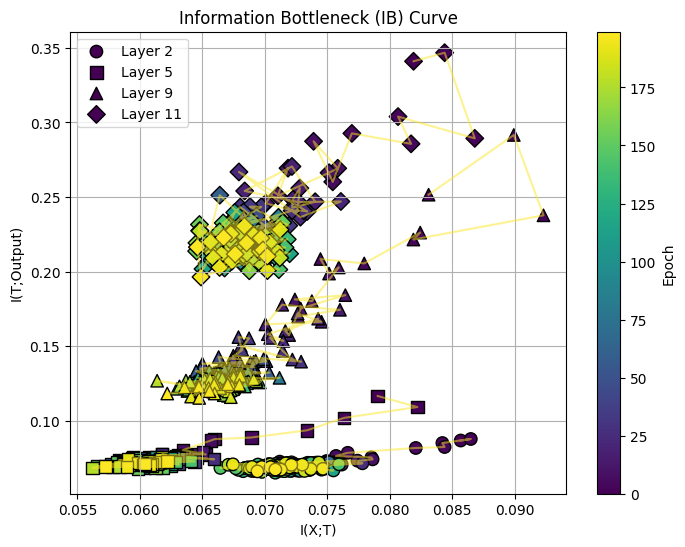

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv("lenet_mi.csv")

# Plot mutual information of each layer vs epoch
plt.figure(figsize=(12, 6))
for col in df.columns:
    if col != "epoch":
        plt.plot(df["epoch"], df[col], label=col)
plt.xlabel("Epoch")
plt.ylabel("Mutual Information")
plt.title("Mutual Information of Each Layer vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Plot IB curve (I(X;T) vs I(T;Output)), color represents epoch, marker shape represents layer, with lines
plt.figure(figsize=(8, 6))
layer_ids = [2, 5, 9, 11]
markers = ['o', 's', '^', 'D']  # Different marker for each layer
cmap = plt.cm.viridis
norm = plt.Normalize(df["epoch"].min(), df["epoch"].max())

for i, layer in enumerate(layer_ids):
    x = df[f"I(X;Layer_{layer})"]
    y = df[f"I(Layer_{layer};Output)"]
    epochs = df["epoch"]
    # Draw lines connecting the points for each layer
    plt.plot(x, y, color=cmap(norm(epochs.iloc[-1])), alpha=0.5)
    # Scatter points with color representing epoch and marker for layer
    sc = plt.scatter(x, y, c=epochs, cmap=cmap, marker=markers[i], label=f"Layer {layer}", edgecolors='k', s=80)

plt.xlabel("I(X;T)")
plt.ylabel("I(T;Output)")
plt.title("Information Bottleneck (IB) Curve")
plt.legend()
cbar = plt.colorbar(sc)
cbar.set_label('Epoch')
plt.grid(True)
plt.show()